# Inverse design optimization of a plasmonic nanoantenna metasurface

In this notebook we perform inverse design of an antenna using a medium ranging between air and an experimentally measured gold from `tidy3d`'s material library.

We use topology optimization to design the patterning on this sheet of gold to maximizes the intensity enhancement in a central location, while respecting fabrication penalties.

This uses the native automatic differentiation support in `tidy3d` >= 2.7.0 through `autograd`.

<img src="img/adjoint_15.png" width=400 alt="Schematic of the nanoantenna ">

## Set up

We start by importing the packages we need, including `autograd` and the `autograd` wrapper for `numpy`.

In [1]:
import autograd
import autograd.numpy as np
import matplotlib.pylab as plt
import tidy3d as td
import tidy3d.web as web

We'll set a few helper constants for the notebook.

In [2]:
# whether to run checks for setting up sim and normalization enhancement
run_pre_sims = True

um = 1e0
nm = 1e-3

Then we define the parameters setting our source spectrum and FDTD spatial resolution.

In [3]:
wavelength = 0.910

freq = td.C_0 / wavelength
fwidth = freq / 10
run_time = 20 / fwidth

dl = 3 * nm

# min_steps_per_wvl = 30

Next we define our material parameters.

We import the gold model from our material library, which is a `td.PoleResidue` medium from a fit to measured data.

In [4]:
# select one of the material library variants
print(tuple(td.material_library["Au"].variants.keys()))

('Olmon2012crystal', 'Olmon2012stripped', 'Olmon2012evaporated', 'Olmon2012Drude', 'JohnsonChristy1972', 'RakicLorentzDrude1998')


In [5]:
medium_SiO2 = td.Medium(permittivity=1.44**2)
medium_gold = td.material_library["Au"]["JohnsonChristy1972"]
eps_background = 1.0

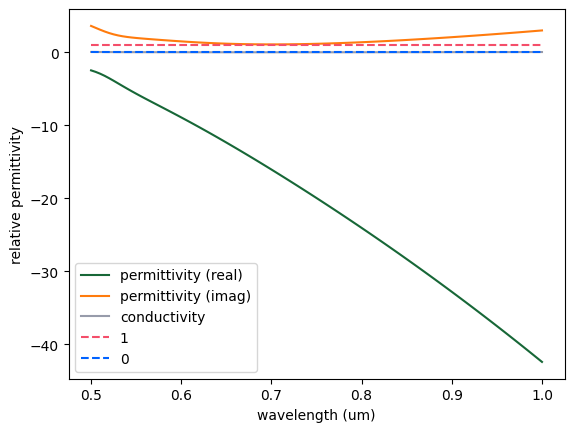

In [6]:
wvls = np.linspace(0.5, 1.0, 101)
freqs = td.C_0 / wvls
eps_complex = medium_gold.eps_model(freqs)
eps_real, sigma = medium_gold.eps_complex_to_eps_sigma(eps_complex, freq=freq)
plt.plot(wvls, eps_real, label="permittivity (real)")
plt.plot(wvls, np.imag(eps_complex), label="permittivity (imag)")
plt.plot(wvls, sigma, label="conductivity")
plt.plot(wvls, np.ones_like(eps_real), label="1", linestyle="--")
plt.plot(wvls, np.zeros_like(eps_real), label="0", linestyle="--")
plt.xlabel("wavelength (um)")
plt.ylabel("relative permittivity")
plt.legend()
plt.show()

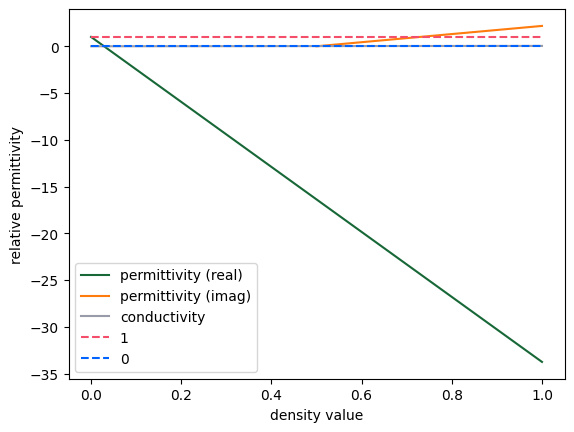

In [7]:
density_values = np.linspace(0, 1, 101)
eps_complex = 0j * np.zeros_like(density_values)
for i, d in enumerate(density_values):
    new_eps_inf = 1.0 + d * (medium_gold.eps_inf - 1)
    new_poles = [(a, c * d) for (a, c) in medium_gold.poles]
    new_medium = medium_gold.updated_copy(eps_inf=new_eps_inf, poles=new_poles)
    eps_complex[i] = new_medium.eps_model(freq)

eps_real, sigma = medium_gold.eps_complex_to_eps_sigma(eps_complex, freq=freq)
plt.plot(density_values, eps_real, label="permittivity (real)")
plt.plot(wvls, eps_complex.imag, label="permittivity (imag)")
plt.plot(density_values, sigma, label="conductivity")
plt.plot(density_values, np.ones_like(eps_real), label="1", linestyle="--")
plt.plot(density_values, np.zeros_like(eps_real), label="0", linestyle="--")
plt.xlabel("density value")
plt.ylabel("relative permittivity")
plt.legend()
plt.show()

Next we define the geometric parameters describing our device.

We have a rectangular metal slab sitting on top of a SiO2 substrate with air on top. 

The rectangular slab has a hole in the center, where we'll be measuring the field intensity enhancement.

In [8]:
size_design_x = 500 * nm
size_design_y = 500 * nm
thick_metal = 50 * nm
thick_sub = 0.8 * wavelength
thick_air = 0.8 * wavelength
buffer_xy = 0.0 * wavelength

hole_radius = 12 * nm

We derive the total sizes needed for our simulation in all dimensions.

In [9]:
size_x = size_design_x + 2 * buffer_xy
size_y = size_design_y + 2 * buffer_xy
size_z = thick_sub + thick_metal + thick_air

As well as set some variables to help us keep track of location within the simulation.

In [10]:
top_z = size_z / 2.0

center_air_z = top_z - thick_air / 2.0
center_metal_z = top_z - thick_air - thick_metal / 2.0
center_sub_z = top_z - thick_air - thick_metal - thick_sub / 2.0

Next, we define our static components, such as the substrate, source, and monitors.

We will include the pattern gold film later on, but we set the geometry as a `td.Box` here so we can use it later.

All of these components will be combined into our base `td.Simulation`, which defines our setup without any gold film.

In [11]:
design_region_geometry = td.Box(
    center=(0, 0, center_metal_z),
    size=(td.inf, td.inf, thick_metal),
)

substrate = td.Structure(
    geometry=td.Box(
        center=(0, 0, -size_z + thick_sub),
        size=(td.inf, td.inf, size_z),
    ),
    medium=medium_SiO2,
)

plane_wave = td.PlaneWave(
    center=(0, 0, center_air_z),
    size=(td.inf, td.inf, 0),
    source_time=td.GaussianPulse(freq0=freq, fwidth=fwidth),
    pol_angle=0,
    direction="-",
)

point_monitor = td.FieldMonitor(
    size=(0, 0, 0),
    center=(0, 0, center_metal_z),
    freqs=[freq],
    name="point",
)

field_monitor_xy = td.FieldMonitor(
    center=(0, 0, center_metal_z),
    size=(td.inf, td.inf, 0),
    freqs=[freq],
    name="field_xy",
)

eps_monitor_xy = td.PermittivityMonitor(
    center=(0, 0, center_metal_z),
    size=(td.inf, td.inf, 0),
    freqs=[freq],
    name="eps_xy",
)

field_monitor_xz = td.FieldMonitor(
    center=(0, 0, 0),
    size=(td.inf, 0, td.inf),
    freqs=[freq],
    name="field_xz",
)

sim_no_antenna = td.Simulation(
    size=(size_x, size_y, size_z),
    run_time=run_time,
    structures=[substrate],
    sources=[plane_wave],
    monitors=[point_monitor, field_monitor_xy, field_monitor_xz, eps_monitor_xy],
    grid_spec=td.GridSpec.uniform(dl=dl),
    boundary_spec=td.BoundarySpec.pml(x=False, y=False, z=True),
    # grid_spec=td.GridSpec.auto(wavelength=wavelength, min_steps_per_wvl=min_steps_per_wvl),
)

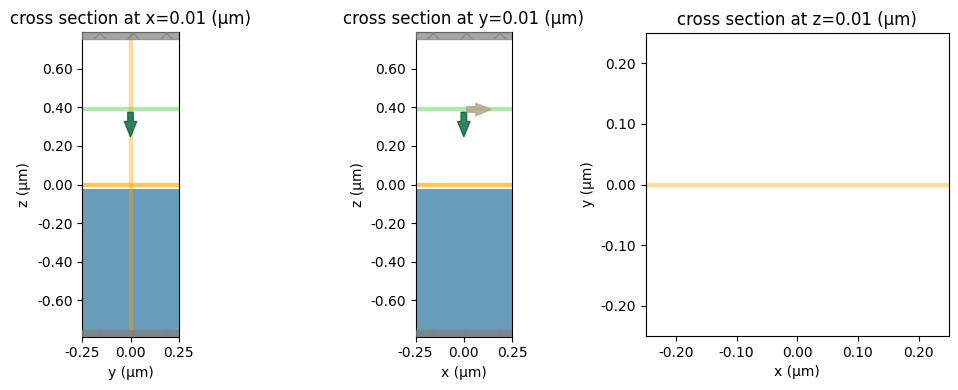

In [12]:
# shift the plot positions a little so the field monitors don't overlap plots
shift_plot = 0.01

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4), tight_layout=True)
sim_no_antenna.plot(x=0.0 + shift_plot, ax=ax1)
sim_no_antenna.plot(y=0.0 + shift_plot, ax=ax2)
sim_no_antenna.plot(z=center_metal_z + shift_plot, ax=ax3)
plt.show()

## Antenna Parameterization

Next, we'll define our antenna as a `td.Structure`, which we add to the simulation.

We will be optimizing this pattern with respect to an array of parameters. So it makes sense to write our components from here on as functions so we can update them as they change.

We start by defining some variables to define our design parameterization, such as the pixel size, feature size, and projection (binarization) strength.

In [13]:
# resolution of the design region pixels
# pixel_size = 10 * nm
pixel_size = dl

# radius of the circular filter (um) (higher = larger features)
radius = 24 * nm

# projection strengths (higher = more binarized)
beta_project = 10
beta_penalty = 10

Next, we write a function to get the density (between 0 and 1) of gold on our film as a function of our optimization parameters.

> Note: there are many helper functions in `tidy3d.plugins.autograd` that are used for inverse design. These have very close analogues in the `adjoint` plugin, but are compatible with `autograd` and have extra features added.

In [14]:
from tidy3d.plugins.autograd import make_filter_and_project


def get_density(params: np.ndarray, beta: float = beta_project) -> np.ndarray:
    """Generic function to get the etch density as a function of design parameters, using filter and projection."""
    filter_project = make_filter_and_project(radius, pixel_size, beta=beta)
    return filter_project(params)

Next, we need to generate the `td.Structure` containing the gold film by modifying the material properties of the gold model from our material library.

We use a `td.CustomPoleResidue` to define a spatially-varying dispersive medium. The relative permittivity at infinite frequency (`eps_inf`) is set between that of air (1) and that of the gold `eps_inf` linearly, depending on the density value at each point. The numerator of the `poles` are also multiplied by the density so that they interpolate between values of 0 for density of 0 and the values for gold when density is 1.

We apply the mask over the central region to set it to air and combine everything together into a `td.Structure`.

In [15]:
def make_antenna_from_density(density: np.ndarray) -> td.Structure:
    """Make a `td.Structure` containing a `td.CustomPoleResidue` corresponding to a density array."""

    rmin, rmax = sim_no_antenna.bounds
    coords = {}
    for key, pt_min, pt_max, num_pts in zip("xyz", rmin, rmax, density.shape):
        coord_edges = np.linspace(pt_min, pt_max, num_pts + 1)
        coord_centers = (coord_edges[1:] + coord_edges[:-1]) / 2.0
        coords[key] = coord_centers

    mask = td.ScalarFieldDataArray(
        np.ones_like(density),
        coords=coords,
    )
    is_in_hole = mask.x**2 + mask.y**2 >= hole_radius**2
    mask = mask.where(is_in_hole, 0)

    density_masked = density * mask.values

    eps_inf_scaled_array = eps_background + density_masked * (medium_gold.eps_inf - eps_background)

    poles_arrays_scaled = [
        (a * np.ones_like(density_masked), c * density_masked) for (a, c) in medium_gold.poles
    ]

    eps_inf_scaled = td.ScalarFieldDataArray(
        eps_inf_scaled_array,
        coords=coords,
    )

    poles_scaled = []
    for a_array, c_array in poles_arrays_scaled:
        a_scaled = td.ScalarFieldDataArray(a_array, coords=coords)
        c_scaled = td.ScalarFieldDataArray(c_array, coords=coords)
        poles_scaled.append((a_scaled, c_scaled))

    medium_gold_scaled = td.CustomPoleResidue(
        eps_inf=eps_inf_scaled, poles=poles_scaled, interp_method="linear"
    )

    return td.Structure(geometry=design_region_geometry, medium=medium_gold_scaled)

Next we write a quick helper function to create the `td.Structure` as a function of the optimization parameters.

In [16]:
def make_antenna(params: np.ndarray, beta: float = beta_project) -> td.Structure:
    """Make the antenna structure."""
    density = get_density(params, beta=beta)
    return make_antenna_from_density(density)

We also write a function that generates a `td.Simulation` with the structure added to our original simulation.

In [17]:
def make_sim_with_antenna(
    params: np.ndarray, include_field_mnts: bool = True, beta: float = beta_project
) -> td.Simulation:
    """Make a simulation as a function of the density parameters for the antenna regions."""

    antenna = make_antenna(params, beta=beta)

    sim = sim_no_antenna.updated_copy(
        structures=list(sim_no_antenna.structures) + [antenna],
    )

    if not include_field_mnts:
        sim = sim.updated_copy(monitors=[point_monitor])

    return sim

Let's test this out by generating a set of initial parameters for the optimization and calling our code.

In [18]:
# some variables we might need later

nx = int(size_design_x // pixel_size)
ny = int(size_design_y // pixel_size)


# some initial parameters to test with
def make_symmetric_x(arr: np.ndarray) -> np.ndarray:
    """make an array symmetric in x."""
    return (arr + np.flipud(arr)) / 2.0


params0 = make_symmetric_x(0.5 * np.ones((nx, ny, 1)))

In [19]:
sim_antenna_params0 = make_sim_with_antenna(params0)

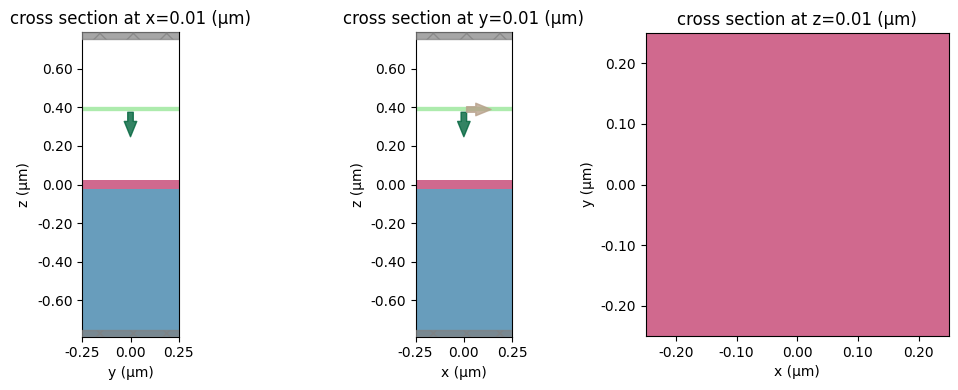

In [20]:
f, axes = f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4), tight_layout=True)
sim_antenna_params0.plot(x=0.0 + shift_plot, monitor_alpha=0.0, ax=ax1)
sim_antenna_params0.plot(y=0.0 + shift_plot, monitor_alpha=0.0, ax=ax2)
sim_antenna_params0.plot(z=center_metal_z + shift_plot, monitor_alpha=0.0, ax=ax3)

for ax in axes:
    ax.set_aspect("equal")

plt.show()

If we want, we can also visualize the initial fields.

15:03:23 CEST Created task 'check fields' with task_id                          
              'fdve-1985e5dc-aa0d-42f9-879b-ce90916fc05c' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=641724;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1985e5dc-aa0d-42f9-879b-ce90916fc05c\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=312801;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1985e5dc-aa0d-42f9-879b-ce90916fc05c\taskId]8;;\]8;id=641724;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1985e5dc-aa0d-42f9-879b-ce90916fc05c\=]8;;\]8;id=558570;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1985e5dc-aa0d-42f9-879b-ce90916fc05c\fdve]8;;\]8;id=641724;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1985e5dc-aa0d-42f9-879b-ce90916fc05c\-1985e5dc-aa]8;;\
              ]8;id=641724;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1985e5dc-aa0d-42f9-879b-ce90916fc05c\0d-42f9-879b-ce90916fc05c']8;;\.

              Task folder: ]8;id=451893;https://tidy3d.simulation.cloud/folders/folder-7a0ee478-ee62-43e0-9a9e-26a06b299b0a\'default']8;;\.

Output()

15:03:25 CEST Maximum FlexCredit cost: 0.563. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

15:03:26 CEST status = success

Output()

15:03:29 CEST loading simulation from simulation_data.hdf5

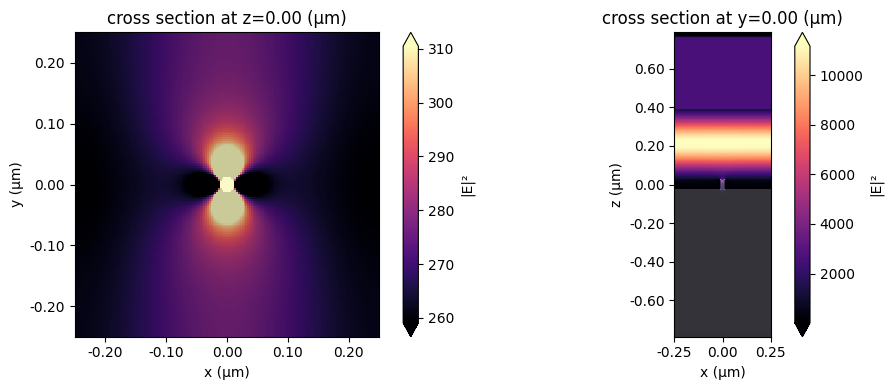

In [21]:
if run_pre_sims:
    sim_data = web.run(sim_antenna_params0, task_name="check fields")
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
    sim_data.plot_field("field_xy", field_name="E", val="abs^2", ax=ax1)
    sim_data.plot_field("field_xz", field_name="E", val="abs^2", ax=ax2)
    plt.show()

Next, we are ready to put everything together into an objective function to optimize.

We start by writing functions to compute the intensity at our measurement point through a `tidy3d` simulation.

In [22]:
def extract_intensity(sim_data: td.SimulationData) -> float:
    """Grab the intensity from a simulation data."""
    return np.sum(sim_data.get_intensity("point").values)


def measure_intensity(
    params: np.ndarray,
    task_name: str = "antenna_intensity",
    verbose=False,
    beta: float = beta_project,
) -> float:
    """Measure intensity as a function of design parameters."""
    sim = make_sim_with_antenna(params, beta=beta, include_field_mnts=False)
    sim_data = web.run(sim, task_name=task_name, verbose=verbose)
    return extract_intensity(sim_data)


if run_pre_sims:
    intensity0 = measure_intensity(
        0 * np.ones_like(params0), task_name="antenna_normalize", verbose=True
    )
else:
    intensity0 = 2083.6917

print(f"Intensity without structure = {intensity0:.4f} (au)")

15:03:30 CEST Created task 'antenna_normalize' with task_id                     
              'fdve-e2220d7b-ccaf-4850-a99d-3bb4e7b19319' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=313008;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e2220d7b-ccaf-4850-a99d-3bb4e7b19319\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=761673;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e2220d7b-ccaf-4850-a99d-3bb4e7b19319\taskId]8;;\]8;id=313008;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e2220d7b-ccaf-4850-a99d-3bb4e7b19319\=]8;;\]8;id=572732;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e2220d7b-ccaf-4850-a99d-3bb4e7b19319\fdve]8;;\]8;id=313008;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e2220d7b-ccaf-4850-a99d-3bb4e7b19319\-e2220d7b-cc]8;;\
              ]8;id=313008;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e2220d7b-ccaf-4850-a99d-3bb4e7b19319\af-4850-a99d-3bb4e7b19319']8;;\.

              Task folder: ]8;id=811249;https://tidy3d.simulation.cloud/folders/folder-7a0ee478-ee62-43e0-9a9e-26a06b299b0a\'default']8;;\.

Output()

15:03:32 CEST Maximum FlexCredit cost: 0.563. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

15:03:33 CEST status = success

Output()

15:03:35 CEST loading simulation from simulation_data.hdf5

Intensity without structure = 2083.6924 (au)


We then define a penalty function to discourage density patterns that have small feature sizes below the `radius` we defined.

In [23]:
from tidy3d.plugins.autograd import make_erosion_dilation_penalty

penalty_fn = make_erosion_dilation_penalty(radius, pixel_size, beta=beta_penalty)


def penalty(params: np.ndarray, beta: float = None) -> float:
    """Define the erosion dilation invariance penalty for Si density parameters."""
    beta_kwargs = {}
    if beta is not None:
        beta_kwargs["beta"] = beta
    density = get_density(params, **beta_kwargs)
    pen_val = penalty_fn(density)
    return pen_val

## Objective Function

Finally, we define our objective function as the ratio of our measured intensity compared to the intensity with no gold film minus the fabrication penalty, which is normalized between 0 and 1.

In [24]:
# let's us grab and print autograd values while they're in the objective function
from autograd.tracer import getval


def intensity_enhancement(
    params: np.ndarray, task_name: str = "antenna_intensity", verbose=False
) -> float:
    intensity_with_params = measure_intensity(params, task_name=task_name, verbose=verbose)
    return intensity_with_params / intensity0


def objective(
    params,
    beta: float = beta_project,
    verbose: bool = False,
    penalty_only: bool = False,
) -> float:
    if penalty_only:
        enhancement_factor = 0.0
    else:
        enhancement_factor = intensity_enhancement(params, verbose=verbose, task_name="antenna")
        print(f"\tenhancement = {getval(enhancement_factor):.2e}")

    # penalty_value = 0
    penalty_value = penalty(params, beta=beta)
    print(f"\tpenalty val = {getval(penalty_value):.2e}")
    objective_value = enhancement_factor * (1.0 - penalty_value)
    print(f"\tobjective = {getval(objective_value):.2e}")
    return objective_value

We can use `autograd` to simply compute a function that returns the value of our objective along with the gradient, to feed to our optimizer.

In [25]:
val_grad_fn = autograd.value_and_grad(objective)

We can take this opportunity to run through the function to verify everything, see our initial objective function value, and visualize the gradients of our objective w.r.t. the initial parameters.

              Created task 'antenna' with task_id                               
              'fdve-4c746aed-5961-41fd-b131-18ccef63ae3c' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=77617;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4c746aed-5961-41fd-b131-18ccef63ae3c\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=505874;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4c746aed-5961-41fd-b131-18ccef63ae3c\taskId]8;;\]8;id=77617;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4c746aed-5961-41fd-b131-18ccef63ae3c\=]8;;\]8;id=821042;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4c746aed-5961-41fd-b131-18ccef63ae3c\fdve]8;;\]8;id=77617;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4c746aed-5961-41fd-b131-18ccef63ae3c\-4c746aed-59]8;;\
              ]8;id=77617;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4c746aed-5961-41fd-b131-18ccef63ae3c\61-41fd-b131-18ccef63ae3c']8;;\.

              Task folder: ]8;id=433234;https://tidy3d.simulation.cloud/folders/folder-7a0ee478-ee62-43e0-9a9e-26a06b299b0a\'default']8;;\.

Output()

15:03:37 CEST Maximum FlexCredit cost: 0.563. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

15:03:38 CEST status = success

Output()

15:03:42 CEST loading simulation from simulation_data.hdf5

Output()

	enhancement = 1.20e+00
	penalty val = 9.98e-01
	objective = 2.18e-03


15:03:45 CEST Started working on Batch containing 1 tasks.

15:03:46 CEST Maximum FlexCredit cost: 0.563 for the whole batch.

              Use 'Batch.real_cost()' to get the billed FlexCredit cost after   
              the Batch has completed.

Output()

15:03:47 CEST Batch complete.

Output()

starting objective function value = 0.0021820630093915628


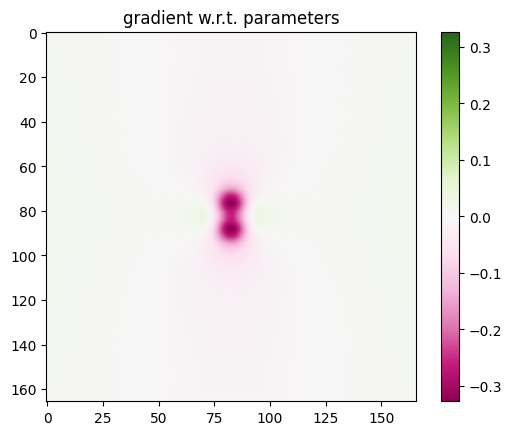

In [26]:
if run_pre_sims:
    val, grad = val_grad_fn(params0, verbose=True)
    print(f"starting objective function value = {val}")
    vmag1 = np.max(abs(grad))
    im1 = plt.imshow(np.flipud(np.squeeze(grad)).T, cmap="PiYG", vmax=vmag1, vmin=-vmag1)
    plt.colorbar(im1)
    plt.title("gradient w.r.t. parameters")

## Optimization

Next, we will use `optax` (an open source optimization package) to optimize this objective function with respect to our parameter array.

Note that the parameters are clipped between 0 and 1.

We will also visualize the density of the gold regions as we go.

step = 1


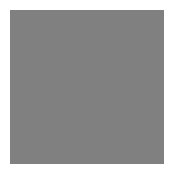

	enhancement = 1.20e+00
	penalty val = 9.98e-01
	objective = 2.18e-03
	beta = 1.0000e+00
	grad_norm = 4.4595e+00
step = 2


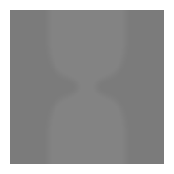

	enhancement = 2.26e+00
	penalty val = 9.98e-01
	objective = 4.37e-03
	beta = 3.7000e+00
	grad_norm = 9.8525e+00
step = 3


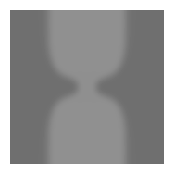

	enhancement = 4.21e+00
	penalty val = 9.97e-01
	objective = 1.36e-02
	beta = 6.4000e+00
	grad_norm = 3.3600e+01
step = 4


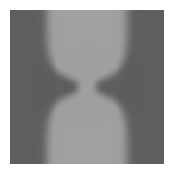

	enhancement = 7.52e+00
	penalty val = 9.90e-01
	objective = 7.75e-02
	beta = 9.1000e+00
	grad_norm = 2.0229e+02
step = 5


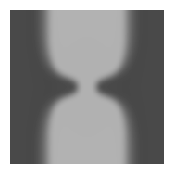

	enhancement = 1.21e+01
	penalty val = 9.56e-01
	objective = 5.33e-01
	beta = 1.1800e+01
	grad_norm = 2.8557e+03
step = 6


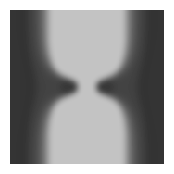

	enhancement = 1.97e+01
	penalty val = 8.39e-01
	objective = 3.18e+00
	beta = 1.4500e+01
	grad_norm = 1.3110e+04
step = 7


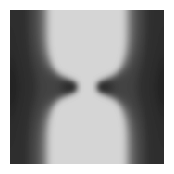

	enhancement = 3.59e+01
	penalty val = 6.67e-01
	objective = 1.20e+01
	beta = 1.7200e+01
	grad_norm = 5.2596e+04
step = 8


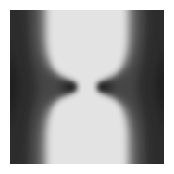

	enhancement = 6.84e+01
	penalty val = 5.85e-01
	objective = 2.84e+01
	beta = 1.9900e+01
	grad_norm = 1.1959e+05
step = 9


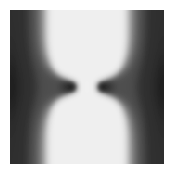

	enhancement = 1.33e+02
	penalty val = 5.78e-01
	objective = 5.63e+01
	beta = 2.2600e+01
	grad_norm = 4.2811e+05
step = 10


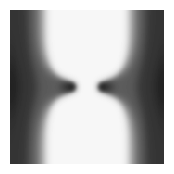

	enhancement = 2.53e+02
	penalty val = 6.00e-01
	objective = 1.01e+02
	beta = 2.5300e+01
	grad_norm = 1.0980e+06
step = 11


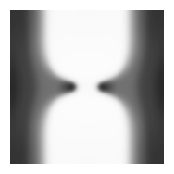

	enhancement = 3.00e+02
	penalty val = 6.25e-01
	objective = 1.13e+02
	beta = 2.8000e+01
	grad_norm = 3.1052e+05
step = 12


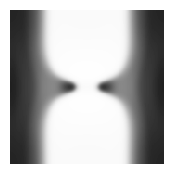

	enhancement = 3.84e+02
	penalty val = 5.49e-01
	objective = 1.73e+02
	beta = 3.0700e+01
	grad_norm = 8.9723e+05
step = 13


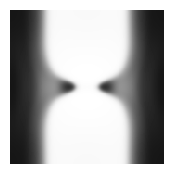

	enhancement = 5.05e+02
	penalty val = 4.59e-01
	objective = 2.73e+02
	beta = 3.3400e+01
	grad_norm = 2.4907e+06
step = 14


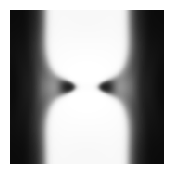

	enhancement = 6.23e+02
	penalty val = 3.92e-01
	objective = 3.79e+02
	beta = 3.6100e+01
	grad_norm = 1.6249e+06
step = 15


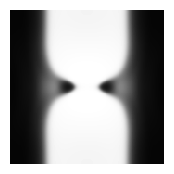

	enhancement = 6.66e+02
	penalty val = 3.35e-01
	objective = 4.43e+02
	beta = 3.8800e+01
	grad_norm = 1.1659e+06
step = 16


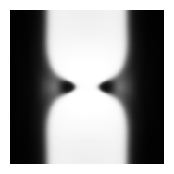

	enhancement = 6.48e+02
	penalty val = 2.84e-01
	objective = 4.64e+02
	beta = 4.1500e+01
	grad_norm = 1.1069e+06
step = 17


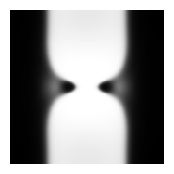

	enhancement = 6.44e+02
	penalty val = 2.56e-01
	objective = 4.79e+02
	beta = 4.4200e+01
	grad_norm = 9.4903e+05
step = 18


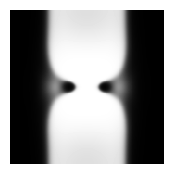

	enhancement = 6.44e+02
	penalty val = 2.45e-01
	objective = 4.86e+02
	beta = 4.6900e+01
	grad_norm = 3.1395e+06
step = 19


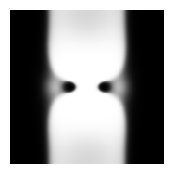

	enhancement = 6.59e+02
	penalty val = 2.39e-01
	objective = 5.01e+02
	beta = 4.9600e+01
	grad_norm = 4.4839e+06
step = 20


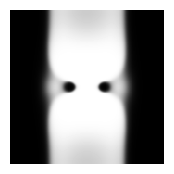

	enhancement = 7.10e+02
	penalty val = 2.30e-01
	objective = 5.46e+02
	beta = 5.2300e+01
	grad_norm = 1.3623e+06


In [27]:
import optax

# hyperparameters
num_steps = 20
learning_rate = 0.01

beta_min = 1.0
beta_max = 55.0


def plot_density(density: np.ndarray, ax=None) -> None:
    """Plot the density of the device."""
    if ax is None:
        _, ax = plt.subplots(figsize=(2, 2))
    arr = np.flipud(1 - density.squeeze().T)
    plt.imshow(arr, cmap="gray", vmin=0, vmax=1, interpolation="none")
    plt.axis("off")
    plt.show()


# initialize adam optimizer with starting parameters (all combined)
params = params0
optimizer = optax.adam(learning_rate=learning_rate)
opt_state = optimizer.init(params)

# store history
objective_values_history = []
params_history = [params]
beta_history = []

# optimization loop
for i in range(num_steps):
    print(f"step = {i + 1}")

    beta = beta_min + i / num_steps * (beta_max - beta_min)
    beta_history.append(beta)

    # plot the densities, to monitor
    plot_density(get_density(params, beta=beta))

    val, grad = val_grad_fn(params, verbose=False, beta=beta)
    gradient = np.array(grad)

    # outputs
    # print(f"\tobjective = {val:.4e}")
    print(f"\tbeta = {beta:.4e}")
    print(f"\tgrad_norm = {np.linalg.norm(gradient):.4e}")

    # compute and apply updates to the optimizer based on gradient (-1 sign to maximize obj_fn)
    updates, opt_state = optimizer.update(-gradient, opt_state, params)
    params[:] = optax.apply_updates(params, updates)

    # clip the parameters between 0 and 1
    np.clip(params, 0.0, 1.0, out=params)

    # save history
    objective_values_history.append(val)
    params_history.append(params)

## Analyze Results

Let's grab and evaluate the final parameters, since we exited the loop without doing this.

In [28]:
params_final = params_history[-1]
beta_final = beta_history[-1]
objective_value_final = objective(params_final, beta=beta_final)
objective_values_history.append(objective_value_final)

	enhancement = 7.21e+02
	penalty val = 2.43e-01
	objective = 5.45e+02


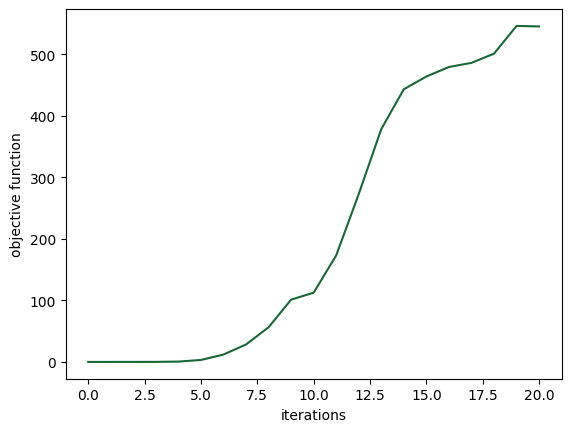

In [29]:
plt.plot(objective_values_history)
plt.xlabel("iterations")
plt.ylabel("objective function")
plt.show()

We can also generate a figure looking at the final fields and density pattern.

In [30]:
sim_final = make_sim_with_antenna(params_final)
sim_data_final = web.run(sim_final, task_name="antenna final")

15:49:45 CEST Created task 'antenna final' with task_id                         
              'fdve-6460c6b4-15d7-4b80-a2ba-4992744bc56f' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=180268;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6460c6b4-15d7-4b80-a2ba-4992744bc56f\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=121868;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6460c6b4-15d7-4b80-a2ba-4992744bc56f\taskId]8;;\]8;id=180268;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6460c6b4-15d7-4b80-a2ba-4992744bc56f\=]8;;\]8;id=224504;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6460c6b4-15d7-4b80-a2ba-4992744bc56f\fdve]8;;\]8;id=180268;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6460c6b4-15d7-4b80-a2ba-4992744bc56f\-6460c6b4-15]8;;\
              ]8;id=180268;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6460c6b4-15d7-4b80-a2ba-4992744bc56f\d7-4b80-a2ba-4992744bc56f']8;;\.

              Task folder: ]8;id=196461;https://tidy3d.simulation.cloud/folders/folder-7a0ee478-ee62-43e0-9a9e-26a06b299b0a\'default']8;;\.

Output()

15:49:48 CEST Maximum FlexCredit cost: 0.563. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

15:49:49 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

15:49:54 CEST status = preprocess

15:49:58 CEST starting up solver

              running solver

Output()

15:50:31 CEST early shutoff detected at 20%, exiting.

              status = postprocess

Output()

15:50:33 CEST status = success

15:50:35 CEST View simulation result at                                         
              ]8;id=225885;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6460c6b4-15d7-4b80-a2ba-4992744bc56f\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=154677;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6460c6b4-15d7-4b80-a2ba-4992744bc56f\taskId]8;;\]8;id=225885;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6460c6b4-15d7-4b80-a2ba-4992744bc56f\=]8;;\]8;id=458499;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6460c6b4-15d7-4b80-a2ba-4992744bc56f\fdve]8;;\]8;id=225885;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6460c6b4-15d7-4b80-a2ba-4992744bc56f\-6460c6b4-15]8;;\
              ]8;id=225885;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6460c6b4-15d7-4b80-a2ba-4992744bc56f\d7-4b80-a2ba-4992744bc56f']8;;\.

Output()

15:50:38 CEST loading simulation from simulation_data.hdf5

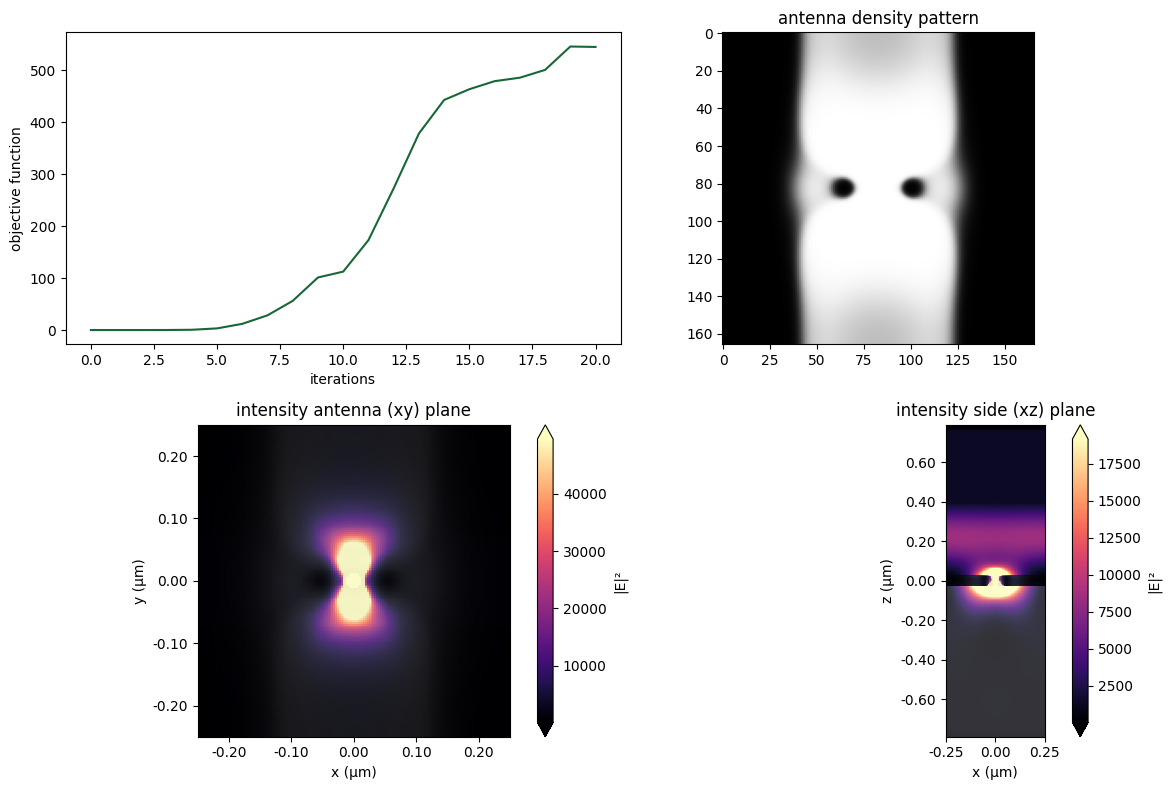

In [31]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8), tight_layout=False)

ax1.plot(objective_values_history)
ax1.set_xlabel("iterations")
ax1.set_ylabel("objective function")

density = get_density(params_final, beta=beta)
ax2.imshow(np.flipud(1 - density.squeeze().T), cmap="grey")
ax2.set_title("antenna density pattern")

sim_data_final.plot_field("field_xy", field_name="E", val="abs^2", ax=ax3)
sim_data_final.plot_field("field_xz", field_name="E", val="abs^2", ax=ax4)
ax3.set_title("intensity antenna (xy) plane")
ax4.set_title("intensity side (xz) plane")

plt.show()